In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import utils

# from  utils import feature_selection as fs
# from  utils import get_top_n_features as top_features

import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/FINAL_FEATURES_TRAINTEST.tsv', sep ='\t')
df.head()

,CLIENT_ID,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,i1067,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,7150,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7154,0.0,16.0,156.0,0.0,0.0,20.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7156,0.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26966,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26993,0.0,27.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
tech_cols = ['CLIENT_ID']
drop_list_singular = utils.drop_singular(df, 0.90)

In [11]:
len(drop_list_singular)

706

In [12]:
df.drop(drop_list_singular, axis = 1, inplace = True)

In [13]:
drop_list_corr = utils.drop_corr(df, tech_cols, 0.75)

In [14]:
len(drop_list_corr)

75

In [15]:
df.drop(drop_list_corr, axis = 1, inplace = True)

In [16]:
df.head()

,CLIENT_ID,i1048,i1059,i1060,i1065,i1070,i1073,i1092,i1139,i1147,...,u7=0.9,u7=1,u7=1.1,u7=1.25,u7=1.5,u7=1.75,u7=2,u7=3,u8=0,u8=0.1
0,7150,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,904.0,1894.0
1,7154,16.0,0.0,20.0,4.0,2.0,0.0,0.0,0.0,1.0,...,0.0,11197.0,0.0,0.0,24.0,0.0,1611.0,17.0,3328.0,14550.0
2,7156,5.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,24.0,...,0.0,0.0,0.0,392.0,0.0,1.0,0.0,0.0,0.0,1004.0
3,26966,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,15.0,0.0,0.0,5.0,305.0,49.0,0.0,530.0,370.0
4,26993,27.0,0.0,0.0,0.0,135.0,0.0,14.0,3.0,0.0,...,1408.0,106184.0,13472.0,694.0,593.0,0.0,301.0,0.0,6164.0,184975.0


In [3]:
x = pd.read_csv('./data/clean_data/TRAIN_TARGETS_DATES.csv', sep = ',')
x.drop(['RETRO_DT'], axis = 1, inplace = True)
x.head()

In [5]:
x = x.merge(df, how = 'left', left_on = 'CLIENT_ID', right_on = 'CLIENT_ID')

In [7]:
x.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,1580286,20210706,0,0.0,42.0,91.0,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68513,20210516,1,0.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1579276,20210704,1,0.0,0.0,67.0,0.0,6.0,8.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1531035,20210523,0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1547532,20210605,0,0.0,0.0,27.0,14.0,0.0,40.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# x.drop(['RETRO_DT'], axis = 1, inplace = True)

In [9]:
x.head()

,CLIENT_ID,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,1580286,0,0.0,42.0,91.0,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68513,1,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1579276,1,0.0,0.0,67.0,0.0,6.0,8.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1531035,0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1547532,0,0.0,0.0,27.0,14.0,0.0,40.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y = pd.read_csv('./data/clean_data/VAL_TARGETS_DATES.csv', sep = ',')
y.drop(['RETRO_DT'], axis = 1, inplace = True)
y.head()

In [13]:
y = y.merge(df, how = 'left', left_on = 'CLIENT_ID', right_on = 'CLIENT_ID')

In [15]:
y.drop(['RETRO_DT'], axis = 1, inplace = True)

In [16]:
y.head()

,CLIENT_ID,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,1021812,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1027507,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1079356,0,0.0,0.0,39.0,0.0,8.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,902.0,0.0,0.0,0.0,0.0
3,1094839,0,0.0,0.0,13.0,0.0,0.0,11.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1116926,0,0.0,13.0,63.0,0.0,6.0,0.0,24.0,0.0,...,0.0,0.0,0.0,0.0,153.0,0.0,0.0,0.0,0.0,0.0


In [30]:
x_train = x.drop(['CLIENT_ID', 'TARGET'], axis = 1)
x_test = y.drop(['CLIENT_ID', 'TARGET'], axis = 1)

y_train = x['TARGET']
y_test = y['TARGET']

In [31]:
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)

LGBMClassifier()

In [32]:
roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

0.5959254707118021

In [34]:
study_lgb = optuna.create_study(direction = 'maximize')
study_lgb.optimize(lambda trial: utils.objective(trial, x_train, y_train, x_test, y_test, 'LightGBM'), n_trials = 100)

[I 2022-09-24 02:36:04,231] A new study created in memory with name: no-name-a9becdfe-7209-46d2-916d-9100a4c5f2fc
[I 2022-09-24 02:36:06,291] Trial 0 finished with value: 0.5770007770927535 and parameters: {'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.44304505215036444, 'colsample_bytree': 0.8947900391358803, 'subsample': 0.4363795979279858, 'reg_lambda': 0.7830063869597813, 'num_leaves': 41, 'scale_pos_weight': 2.3337081918387375}. Best is trial 0 with value: 0.5770007770927535.
[I 2022-09-24 02:36:07,416] Trial 1 finished with value: 0.5856069290344792 and parameters: {'n_estimators': 11, 'max_depth': 3, 'learning_rate': 0.4755223061466617, 'colsample_bytree': 0.5410726577971912, 'subsample': 0.6139577403370957, 'reg_lambda': 0.15982251348035154, 'num_leaves': 256, 'scale_pos_weight': 2.144092393448159}. Best is trial 1 with value: 0.5856069290344792.
[I 2022-09-24 02:36:08,789] Trial 2 finished with value: 0.5874921912240043 and parameters: {'n_estimators': 14, 'max_depth'

[I 2022-09-24 02:36:46,952] Trial 21 finished with value: 0.5920831043475514 and parameters: {'n_estimators': 46, 'max_depth': 5, 'learning_rate': 0.06295542156590271, 'colsample_bytree': 0.4345765291350605, 'subsample': 0.67010033888342, 'reg_lambda': 0.23160539905816627, 'num_leaves': 153, 'scale_pos_weight': 1.4982954926907854}. Best is trial 17 with value: 0.597766541319211.
[I 2022-09-24 02:36:49,761] Trial 22 finished with value: 0.5970202374316478 and parameters: {'n_estimators': 73, 'max_depth': 7, 'learning_rate': 0.0959765684209784, 'colsample_bytree': 0.5422068600167582, 'subsample': 0.6976953719566561, 'reg_lambda': 0.4062637227306227, 'num_leaves': 108, 'scale_pos_weight': 1.5094565514427098}. Best is trial 17 with value: 0.597766541319211.
[I 2022-09-24 02:36:52,191] Trial 23 finished with value: 0.5941712412943089 and parameters: {'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.1814850070938695, 'colsample_bytree': 0.5147851623968199, 'subsample': 0.68527751413754

[I 2022-09-24 02:37:34,953] Trial 42 finished with value: 0.5759940275129338 and parameters: {'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.5001259693870892, 'colsample_bytree': 0.4295175253019535, 'subsample': 0.5232205014229007, 'reg_lambda': 0.6601233869994881, 'num_leaves': 145, 'scale_pos_weight': 1.8289036659586595}. Best is trial 29 with value: 0.5983163602976564.
[I 2022-09-24 02:37:37,531] Trial 43 finished with value: 0.5961619184552893 and parameters: {'n_estimators': 77, 'max_depth': 6, 'learning_rate': 0.11545146125819221, 'colsample_bytree': 0.40015924446962386, 'subsample': 0.6299187540122122, 'reg_lambda': 0.7218446545929567, 'num_leaves': 120, 'scale_pos_weight': 2.058918280944678}. Best is trial 29 with value: 0.5983163602976564.
[I 2022-09-24 02:37:39,642] Trial 44 finished with value: 0.5815960085231617 and parameters: {'n_estimators': 62, 'max_depth': 6, 'learning_rate': 0.40708304156084474, 'colsample_bytree': 0.4810011680774009, 'subsample': 0.7376056398

[I 2022-09-24 02:38:37,967] Trial 63 finished with value: 0.5991102434381828 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.054149725615161695, 'colsample_bytree': 0.8460024827307597, 'subsample': 0.8201346506255087, 'reg_lambda': 0.28988664520839985, 'num_leaves': 221, 'scale_pos_weight': 1.0725789537397552}. Best is trial 57 with value: 0.6036089223555811.
[I 2022-09-24 02:38:42,464] Trial 64 finished with value: 0.6005629000605638 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.05571952646599557, 'colsample_bytree': 0.8401338730944236, 'subsample': 0.8157267871055766, 'reg_lambda': 0.2686474053589012, 'num_leaves': 212, 'scale_pos_weight': 1.1392358577267985}. Best is trial 57 with value: 0.6036089223555811.
[I 2022-09-24 02:38:46,966] Trial 65 finished with value: 0.5997004964098165 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.05364541970247588, 'colsample_bytree': 0.8456527997832334, 'subsample': 0.81813

[I 2022-09-24 02:40:07,813] Trial 84 finished with value: 0.597576629270311 and parameters: {'n_estimators': 95, 'max_depth': 8, 'learning_rate': 0.06763004827077027, 'colsample_bytree': 0.8577666106873315, 'subsample': 0.7783863205992548, 'reg_lambda': 0.1681747825776454, 'num_leaves': 203, 'scale_pos_weight': 1.2243143578935436}. Best is trial 57 with value: 0.6036089223555811.
[I 2022-09-24 02:40:11,671] Trial 85 finished with value: 0.5966334160413052 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.10418808256895726, 'colsample_bytree': 0.7988515914372947, 'subsample': 0.8034715933692577, 'reg_lambda': 0.13372864358400915, 'num_leaves': 240, 'scale_pos_weight': 1.0605934264279204}. Best is trial 57 with value: 0.6036089223555811.
[I 2022-09-24 02:40:15,722] Trial 86 finished with value: 0.6007728460939548 and parameters: {'n_estimators': 91, 'max_depth': 8, 'learning_rate': 0.05621871704522601, 'colsample_bytree': 0.7274445672009457, 'subsample': 0.83792020

In [35]:
study_lgb.best_trial.params

{'n_estimators': 100,
 'max_depth': 8,
 'learning_rate': 0.07834515928323184,
 'colsample_bytree': 0.4205344863233677,
 'subsample': 0.7866866160061953,
 'reg_lambda': 0.5120001251851827,
 'num_leaves': 157,
 'scale_pos_weight': 1.2962323871002674}

In [37]:
params = study_lgb.best_trial.params

In [38]:
argList = utils.get_top_features('LightGBM', 'TARGET', params, x_train, y_train, x_test, y_test)

C:\Users\zungl\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


MemoryError: Unable to allocate 181. MiB for an array with shape (101946, 233) and data type float64

In [ ]:
# for i, col in enumerate(x.columns):
#     x.rename({col: f'x_{i}'}, inplace = True, axis = 1)

In [32]:
len(argList)

30

In [33]:
argList2 = utils.fs.backward_selection(argList, model, x_train, y_train, x_test, y_test)

ROC AUC Test initial = 0.5891011713335323
Осталось фичей: 29, ROC AUC = 0.5894499768267738, удалена фича u2=83
Осталось фичей: 28, ROC AUC = 0.5885691278923466, удалена фича i1681
Осталось фичей: 27, ROC AUC = 0.5886394863113488, удалена фича i645
Осталось фичей: 26, ROC AUC = 0.5884983294655217, удалена фича u7=2
Осталось фичей: 25, ROC AUC = 0.5885719548452601, удалена фича i647
Осталось фичей: 24, ROC AUC = 0.5887033108088786, удалена фича u8=0.1
Осталось фичей: 23, ROC AUC = 0.5915560139147763, удалена фича u7=1.5
Осталось фичей: 22, ROC AUC = 0.5916092743306881, удалена фича u5=2
Осталось фичей: 21, ROC AUC = 0.5903144481249001, удалена фича u0=22
Осталось фичей: 20, ROC AUC = 0.5901461392919292, удалена фича u2=19
Осталось фичей: 19, ROC AUC = 0.587914875198829, удалена фича i680
Осталось фичей: 18, ROC AUC = 0.5873311911935386, удалена фича i4512


In [34]:
len(argList2)

18

In [35]:
argList2

['i523',
 'i1465',
 'i453',
 'i3358',
 'u8=0',
 'u2=54',
 'u2=76',
 'u1=187',
 'u2=66',
 'i465',
 'u7=1',
 'i715',
 'i831',
 'u2=15',
 'i1411',
 'i4292',
 'u1=160',
 'i883']

In [36]:
study_lgb2 = optuna.create_study(direction = 'maximize')
study_lgb2.optimize(lambda trial: utils.objective(trial, x_train[argList2], y_train, x_test[argList2], y_test, 'LightGBM'), n_trials = 100)

[I 2022-09-23 22:06:13,535] A new study created in memory with name: no-name-85886a62-ce0f-4080-a2a8-a9cdd7484ed6
[I 2022-09-23 22:06:13,703] Trial 0 finished with value: 0.5811574609034749 and parameters: {'n_estimators': 21, 'max_depth': 3, 'learning_rate': 0.2832146567488762, 'colsample_bytree': 0.5879444069764505, 'subsample': 0.6140346590128983, 'reg_lambda': 0.8190362470911217, 'num_leaves': 86, 'scale_pos_weight': 1.231267331526436}. Best is trial 0 with value: 0.5811574609034749.
[I 2022-09-23 22:06:13,875] Trial 1 finished with value: 0.5808517021932358 and parameters: {'n_estimators': 39, 'max_depth': 3, 'learning_rate': 0.24258039464112455, 'colsample_bytree': 0.9266537205329702, 'subsample': 0.6000793114971747, 'reg_lambda': 0.6630318649576263, 'num_leaves': 127, 'scale_pos_weight': 2.054607397138787}. Best is trial 0 with value: 0.5811574609034749.
[I 2022-09-23 22:06:14,059] Trial 2 finished with value: 0.5788985230440429 and parameters: {'n_estimators': 27, 'max_depth': 

In [38]:
model = lgb.LGBMClassifier(**study_lgb.best_trial.params)

In [39]:
model.fit(x_train[argList2], y_train)

LGBMClassifier(colsample_bytree=0.9671160457816894,
               learning_rate=0.07204167908092876, max_depth=7, n_estimators=79,
               num_leaves=202, reg_lambda=0.39866356827980154,
               scale_pos_weight=1.6916625423864726,
               subsample=0.40545546099882546)

In [40]:
probs_train = model.predict_proba(x_train[argList2])[:, 1]
probs_test = model.predict_proba(x_test[argList2])[:, 1]

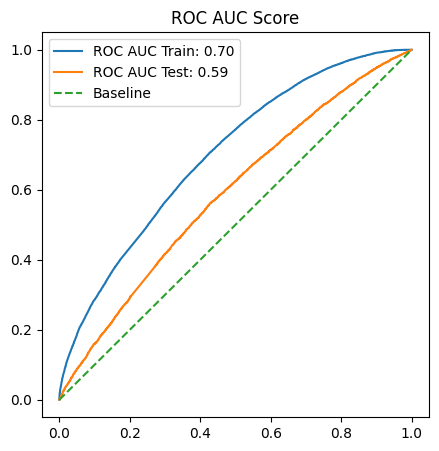

In [51]:
roc_train = roc_auc_score(y_train, probs_train)
roc_test = roc_auc_score(y_test, probs_test)

tpr_train, fpr_train, _ = roc_curve(y_train, probs_train)
tpr_test, fpr_test, _ = roc_curve(y_test, probs_test)

fig = plt.figure(figsize = (5, 5))
plt.plot(tpr_train, fpr_train, label = f'ROC AUC Train: {roc_train:.2f}')
plt.plot(tpr_test, fpr_test, label = f'ROC AUC Test: {roc_test:.2f}')
plt.plot([0, 1], [0,1], label = 'Baseline', ls = '--')
plt.title('ROC AUC Score')
plt.legend()
plt.show()

In [56]:
y_train.sum()/y_train.shape[0], y_test.sum()/y_test.shape[0]

(0.2749200557157711, 0.2712861963430903)

In [57]:
model.booster_.save_model('model_classic.txt')